In [1]:
# Import libraries
import ast
import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import glob, os
import re
import math
from tqdm import tqdm
from scipy.stats import stats
from scipy.stats import mannwhitneyu
import itertools
import seaborn as sns

# To make the plot in the notebook and not in an extra window
%matplotlib notebook 

# Implement error messages (Default should be True)
error_on_missing_timestamps = False
error_on_time_light_mismatch = False
error_on_time_behavior_mismatch = False
error_on_missing_behaviors = False
error_on_invalid_behavior_range = False

Part 1: Generation of single data frame per sample, including behavior annotation, timestamp and dff

In [2]:
#Open multiple .csv from single directory. Define existing behaviors. Define sample_ID and experiment_ID.
# Chris's FRAN is zero based!!, whereas old annotations are 1 based
#directory for behavior data

behavior_directories = [r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_cl_A4/',
                        #r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_cl_A9/',
                        #r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_ol/',
                        #r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_stim_artefact/'
                       ] 

behavior_files = []
for d in behavior_directories:
    behavior_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename, 

# Behavior columns available in CSV files
available_behaviors = ('fw', 'bw', 'stim', 'hunch', 'turn', 'other', 'HP', 'left turn', 'right turn')

# Regular expression (define the expression filenames are searched for)
# '.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
# '+' 1>> occurences, 'L' here character from filename
# () outcome here: 2 groups, useful for extraction
# [] optional list, eg 1 --> 1
# ? character non or once 

# Behavior reg-ex (regular expression)
behavior_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-behavior-(.+).csv')

# Function: readall_behavior iterates through all csv (sorted) 
# and appends the files into the list (ls) and returns dictionary
def readall_behavior(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample 
        # (cl (closeloop, RGECO/ Chronos), ol (openloop, RGECO/ Chronos), 
        # blocks (Raghav: GCaMP/Chrimson))
        # Larva ID: YY-MM-DDLX
        # Look for filename_components, which are true for pattern
        match = behavior_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        #define filename_components sample_id (first group), and exp_id (sec group)
        part_sample_id, _, exp_id = filename_components         
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ';')
        df.fillna(0, inplace=True) #replace NaN with zero
        df['sample_id'] = sample_id  #add sample_id column
        df['exp_id'] = exp_id #add exp_id column
        data[sample_id] = df
        #Count 'True' for each column ('behavior') in each single behavior.csv)
        #print(filename, df[df == 1].count()) 
        #print(df)
    return data

behavior_data = readall_behavior(behavior_files)
#print(behavior_data['17-11-06L2-cl'])



In [3]:
# Frequency of each behavior in all imported behavior.csv by using the returned 'ls' from 
# the function readAll: concatenate the 'behavior_files' (global variable). 'True' for each 
# column ('behavior_type') in the concatenated file (df_behavior).
# Sorting has to be = False (warning message without 'sort')
df_behavior = pd.concat(behavior_data.values(), axis = 0, ignore_index = True, sort = False) #add sorting
print(df_behavior[df_behavior == 1].count()) 

START             8
END               0
fw             3644
bw              711
stim            201
hunch           326
turn           1508
other           136
HP              496
left turn       769
right turn      739
sample_id         0
exp_id            0
Unnamed: 11       0
dtype: int64


In [4]:
# Import and merge fluorescence data: Several LM files for the same sample_id exists, but differ in cell_id).
# List of LM data with two extra columns: sample_id and cell_id
# Open LM files from different directories
lightmicroscope_directories = [r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/Basin_traces/', 
                               r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/Handle-like_Traces',
                               r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/a00c_traces',
                               #r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/candidate_neuron_traces'
                              ] 

# Iterate through LM data and extend files in a list from within and between directory and 
# build a list of files from all directories
# (Note: append would 'extend' lists and not single files)
lightmicroscope_files = []
for d in lightmicroscope_directories:
    lightmicroscope_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename

# Lightmicroscopic data reg-ex (regular expression)
lightmicroscope_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-(.*)-(.*).csv')

# Function: readall_lm iterates through all LM_csv (sorted) 
# and returns a dictionary{key:value} 
# samples = {sample_id:cell-id}
def readall_lm(all_files):
    samples = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # Larva ID: YY-MM-DDLX, DETAIL = cell_id
        # Look for filename_components, which are true for pattern
        match = lightmicroscope_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, cell_id, exp_id = filename_components
        
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        # Read LM.files 
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ',')
        # Replace NaN with zero
        df.fillna(0, inplace=True)
        
        # Add cellname to each column as prefix
        # lambda is a non defined function (longer version: def lambda(x):)
        # Rename of columns after the format cell_id, name) eg: Basin A9
        # inplace = True: column names are overwritten (if False: new dataframe)
        df.rename(lambda x: '{}_{}'.format(cell_id, x), axis = 'columns', inplace = True)
        # Get the sample_id (key) from the dictionary? to make a list [sample_cells] and 
        # if sample_id exists, append the list
        # if sample_id does not exists, start a new list
        # reminder: there can be several cell_id per sample_id
        sample_cells = samples.get(sample_id)
        if not sample_cells:
            samples[sample_id] = sample_cells = {
                'data': [],
                'exp_id': exp_id,
            }
        sample_cells['data'].append(df)
        
    return samples

lm_samples = readall_lm(lightmicroscope_files)

# New dictionary: lm_data{} to build a single dataframe with all cell_ids combined 
# for a single sample. Iterate over dict from same sample in one dataframe. 
# df.items iterate over pairs and build a list

lm_data = {}

# Iterate over all light samples and merge all found files
# for each sample into a single data frame (per sample)
for sample_id, sample_info in lm_samples.items():
    cells_dataframes = sample_info['data']
    #check if number of cells >= 1
    if not cells_dataframes:
        raise ValueError('No cells found for sample {}'.format(sample_id))
    #first element in the list
    lm_df = None

    #iteration through other df
    for cdf in cells_dataframes:
        if lm_df is None:
            lm_df = cdf
        else:
            if len(lm_df.index) != len(cdf.index):
                raise ValueError('Data frame frame to merge has not same row count as target', sample_id)
            lm_df = pd.merge(lm_df, cdf, left_index = True, right_index = True)
            
    lm_df['sample_id'] = sample_id  #add sample_id column
    lm_df['exp_id'] = sample_info['exp_id']
    lm_data[sample_id] = lm_df
#print(list(lm_data.keys()))

In [5]:
# Import txt-files from of the absolute time/frame from the Ca-imaging (lm-data). 
# All txt-files have to be transposed, which is a memory intensive step. After the 
# data are complete, the transposed files should be exported (ToDo). Time-data are 
# combined with sample-ID and experiment-ID.

timelapse_directory =(r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/timelapse/') 
timelapse_files = glob.glob(os.path.join(timelapse_directory, "*.txt")) #join pathname with filename

# Behavior reg-ex (regular expression)
time_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-time-(.+).txt')

# Function: readall_timelapse iterates through all txt (sorted) and appends the 
# files into the dict (data) and returns ls
def readall_time(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample (cl (closeloop), ol (openloop), blocks (Raghav))
        # Larva ID: YY-MM-DDLX
        #look for filename_components, which are true for pattern
        match = time_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, exp_id = filename_components #define filename_components sample_id (first group), and exp_id (sec group)  
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, header=1, index_col=None, delim_whitespace = True)
        df = df.T #transposing because read_csv imports as row
        df = df.reset_index() #transpose function sets data as index
        df.rename(columns={'index':'time'}, inplace=True) #rename reset index column to time
        df['time'] = df.time.astype(float)
        data[sample_id] = df
        
    return data

In [6]:
# Keep in mind that some of the files has to be changed because of the discrepancy in timestamps
timelapse_cache = 'timelapse.cache'

try:
    with open(timelapse_cache, 'r') as timelapse_cache_file:
        # TODO
        cache_data = timelapse_cache_file.read()
        time_data = ast.literal_eval(cache_data)
except FileNotFoundError as e:
    print('No cache file found, recomputing')
    # No cache file found, recompute
    time_data = readall_time(timelapse_files)
    # Write cache
    

No cache file found, recomputing


17-08-24L5-cl: time data (6686 entries) doesn't match light data (6685 entries)
17-08-26L1-cl: time data (6990 entries) doesn't match light data (6989 entries)
17-08-26L3-cl: time data (2935 entries) doesn't match light data (4110 entries)
17-08-27L2-cl: time data (6470 entries) doesn't match light data (6469 entries)
17-08-28L3-cl: time data (6228 entries) doesn't match light data (6225 entries)
17-08-29L2-cl: time data (6817 entries) doesn't match light data (6805 entries)
17-11-03L7-cl: time data (1399 entries) doesn't match light data (2657 entries)
17-11-04L1-cl: time data (6325 entries) doesn't match light data (6324 entries)
17-11-06L1-cl: time data (1923 entries) doesn't match light data (6493 entries)
17-11-08L3-cl: time data (3240 entries) doesn't match light data (6474 entries)
17-11-26L1-cl: time data (6487 entries) doesn't match light data (6469 entries)
17-11-29L3-cl: time data (6567 entries) doesn't match light data (6561 entries)
17-11-30L2-cl: time data (6640 entries) 

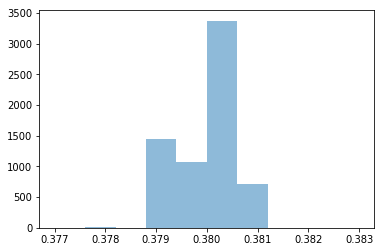

In [7]:
sample_data = {}

# Time data are merged into light data and checked if number length of lm = timestamp.  
# Due to technical conditions, some time.txt-file have too many or not enough time data compared
# to the corresponding LM data. The discrepancy is fixed by either dropping the extra timepoints or 
# by taking the average of the difference between each timepoint and extend the dataframe. 
# The first 10 timepoints are not included to account for instability of the microscope in 
# the beginning due to the moving parts. 
# Maximal difference between timepoints fyi.

for sample_id, sample_df in lm_data.items():
    # Add time stamps to data frame of current sample by merging
    # The time data frame for the current sample, which is expected
    # to match the light data (based on index).
    timestamp_df = time_data.get(sample_id)
    if timestamp_df is None:
        msg = '{}: could not find timestamp data for sample'.format(sample_id)
        if error_on_missing_timestamps:
            raise ValueError(msg)
        # Ignore, if missing data shouldn't cancel the whole process.
        print(msg)
        continue
        
    n_timestamps = len(timestamp_df)
    n_lightdata = len(sample_df)
    
    # The timestamp and light recordings are done by different systems.
    # This can cause the existence of additional time points/ or missing time points in a
    # dataset, which will be filtered out in the merge operation below.
    if n_lightdata != n_timestamps:
        msg = '{}: time data ({} entries) doesn\'t match light data ({} entries)'.format(
                sample_id, n_timestamps, n_lightdata)
        if error_on_time_light_mismatch:
            raise ValueError(msg)
        print(msg)
        diffs = np.diff(timestamp_df['time'])[10:] #from 10th row onwards
        diffs_avg = diffs.mean(axis=0)
        #diff between timedata and lightdata
        missing_data = len(sample_df) - len(timestamp_df)
        
        #add 'diffs_avg' to fill in missing_timedata
        if missing_data > 0:
            last_valid_index = len(timestamp_df) - 1
            last_timestamp = timestamp_df.iloc[last_valid_index]['time']
            if pd.isna(last_timestamp):
                raise ValueError('Unexpected last valid timestamp for sample {} at index {}'.format(
                        sample_id, last_valid_index))
            for i in range(0, missing_data):
                last_valid_index += 1
                timestamp_df.loc[last_valid_index] = timestamp_df.iloc[last_valid_index - 1]['time'] + diffs_avg
        elif missing_data < 0:
            drop_start = len(timestamp_df) + missing_data
            drop_end = len(timestamp_df)
            timestamp_df.drop(list(range(drop_start, drop_end)))

    # Merge timedata into light data
    # Use an 'inner' join/merge to exclude time points that don't have matching light data.
    new_sample_df = pd.merge(sample_df, timestamp_df, left_index = True, right_index = True, how='inner')
    
    # Store newly created data frame for sample (dictionary)
    sample_data[sample_id] = new_sample_df
    
print('Matched {} light data sets with their respective time points'.format(len(sample_data)))

# Max.diffs for timestamps
# diffs defined earlier
mx = diffs.max()
print('max-diff', mx)

plt.hist(diffs, bins=10, alpha=0.5)
plt.show() 

In [8]:
# Combine behavior data with light data into a single data frame
# per sample ID. To do so, add behavior data to light data frames,
# because the light data is already organizes by frame. To accomodate
# frame ranges without an behavior data, a column named "quiet" is
# added which is True in these cases and False otherwise. Additionally,
# for each behavior column, a behavior start and end column as well as
# an overlap column is added so that parallel and successive behaviors
# of the same type can be differentiated.

for sample_id, sample_df in sample_data.items():
    sample_behavior = behavior_data.get(sample_id)
    if sample_behavior is None:
        msg = 'Could not find behavior data for sample "{}"'.format(sample_id)
        if error_on_missing_behaviors:
            raise ValueError(msg)
        print(msg)
        continue

    # Add extra columns for behavior
    for behavior in available_behaviors:
        sample_df[behavior] = False
        sample_df['{}_start'.format(behavior)] = False
        sample_df['{}_end'.format(behavior)] = False
        sample_df['{}_overlap'.format(behavior)] = False
    
    # Add 'quiet' column. Set it initially to True and mark frames
    # with actual behavior as quiet = False.
    sample_df['quiet'] = True
    
    n_light_entries = len(sample_df)

    # Iterate over behavior data and add data to target data frame
    for i, row in sample_behavior.iterrows():
        # Start and end are 1-based, make them 0-based
        start = int(row['START'])
        end = int(row['END'])
        
        if type(row['START']) == str:
            print(sample_id)
            print(start, end)
        
        if start >= end:
            msg = "{}: start ({}) needs to be strictly smaller than end ({})".format(sample_id, start, end)
            if error_on_invalid_behavior_range:
                raise ValueError(msg)
            print(msg)
            continue
        
        # Make sure we capture start/end times that are a fractional number.
        if row['START'] - start > 0 or row['END'] - end > 0:
            raise ValueError('{}: start and end frame number can\'t contain fractions'.format(sample_id))
            
        # Ignore behavior entries with an end frame higher than available light data.
        # The behavior data is one-based, which is why a strict larger than test should
        # be correct.
        if end > n_light_entries:
            msg = 'Sample: {} - Behavior row with range {}-{} exceeds light time points ({}): {}'.format(
                sample_id, start, end, n_light_entries, row)
            if error_on_time_behavior_mismatch:
                raise ValueError(msg)
            print(msg)
            continue
            
        # Find behavior observed in row
        observed_behaviors = []
        for behavior in available_behaviors:
            if row[behavior]:
                observed_behaviors.append(behavior)
        
        # We assume that not more than two behaviors are observed at the same time
        if len(observed_behaviors) > 2:
            raise ValueError('Found multiple behaviors in row {} of sample {}'.format(i, sample_id))
        
        # Add observed behavior information to target data frames in all
        # rows in behavior range.
        for b in observed_behaviors:
            # Iterate over frames valid for current behavior. Every valid
            # frame is mapped into the canonical (light/cell) data frame,
            # which is 0-indexed.
            for j in range(start, end + 1):
                # Behavior ranges are 1-indexed
                current_frame = j - 1
                # If the current behavior has already been observed at this frame,
                # set overlap to True, because we are about to mark this behavior
                # again as observed for this frame.
                if sample_df.at[current_frame, b]:
                    sample_df.at[current_frame, '{}_overlap'.format(b)] = True
                else:
                    sample_df.at[current_frame, b] = True
                
                # Mark this row as not quiet, because we observed
                # a behavior in the current frame.
                sample_df.at[current_frame, 'quiet'] = False

            sample_df.at[start - 1, '{}_start'.format(b)] = True
            sample_df.at[end - 1, '{}_end'.format(b)] = True
            
    # Mark quiet ranges with _start, _end and _overlap. By definion,
    # quiet_overlap is always False.
    sample_df['quiet_start'] = False
    sample_df['quiet_end'] = False
    sample_df['quiet_overlap'] = False
    last_sample_idx = n_light_entries - 1
    for i, row in sample_df.iterrows():
        sample_df.at[i, 'quiet_start'] = row['quiet'] and (i == 0 or not sample_df.at[i - 1, 'quiet'])
        sample_df.at[i, 'quiet_end'] = row['quiet'] and (i == last_sample_idx or not sample_df.at[i + 1, 'quiet'])

Could not find behavior data for sample "17-11-02L3-cl"
Could not find behavior data for sample "17-11-03L1-cl"
Could not find behavior data for sample "17-11-03L2-cl"
Could not find behavior data for sample "17-11-03L3-cl"
Could not find behavior data for sample "17-11-03L5-cl"
Could not find behavior data for sample "17-11-03L6-1-cl"
Could not find behavior data for sample "17-11-03L6-2-cl"
Could not find behavior data for sample "17-11-03L7-cl"
Could not find behavior data for sample "17-11-04L1-cl"
Could not find behavior data for sample "17-11-04L2-cl"
Could not find behavior data for sample "17-11-04L3-cl"
Could not find behavior data for sample "17-11-04L4-cl"
Could not find behavior data for sample "17-11-05L6-cl"
Could not find behavior data for sample "17-11-05L7-cl"
Could not find behavior data for sample "17-11-06L1-cl"
Could not find behavior data for sample "17-11-06L2-cl"
Could not find behavior data for sample "17-11-06L3-cl"
Could not find behavior data for sample "17-

Part 2: Data-analysis

In [9]:
# Define a class with sample_id, cell_type, event_name and filter_pattern

class CellTraceConfig:
    
    def __init__(self, sample_id, cell_type, event_name, filter_pattern=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_name = event_name
        self.filter_pattern = filter_pattern
        
    def get_filter_regex(self):
        filter_regex = '^{}_'.format(self.cell_type)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    def get_event_start_col(self):
        return '{}_start'.format(self.event_name)

    def add_event_time_points_to_plot(self, source_df, plot):
        for idx, row in source_df.iterrows():
            plot.annotate(self.event_name, xy=(row['time'], 1))
            plt.axvline(row['time'], color='k', linestyle='-')  
            
# Define a class with sample_id, cell_type, event_time and filter_pattern (for behavioral_transitions)
# Put '' [empty string] if you dont want any cell type

class CellTransConfig:
    
    def __init__(self, sample_id, cell_type, event_time, filter_pattern=None, first_event=None, second_event=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_time = event_time
        self.filter_pattern = filter_pattern
        self.first_event = first_event
        self.second_event = second_event
        
    def get_filter_regex(self):
        if self.cell_type is None:
            cell_str = r"[a-zA-Z0-9]+"
        else:
            cell_str = self.cell_type
            
        filter_regex = '^{}_'.format(cell_str)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    
    
# Define a class for filtering after behavioral_transitions for either only cell_type or filter_pattern or both.
# For example to average not only over all A00cs but all A00c_midL.

class DataFilter():
    def __init__(self, cell=None, pattern=None):
        self.cell = cell if cell is not None else '.*' # Makes argument optional
        self.pattern = pattern if pattern is not None else '.*' # Makes argument optional
        
    def get_cell_filter_regex(self):
        filter_regex = '.*_{}_.*_.*'.format(self.cell)
        return filter_regex
    
    def get_pattern_filter_regex(self):
        filter_regex = '.*_.*_{}_.*'.format(self.pattern)
        return filter_regex
    
    def get_cellpattern_filter_regex(self):
        filter_regex = '.*_{}_{}_.*'.format(self.cell, self.pattern)
        return filter_regex
        
    def __str__(self):
        return "{}_{}".format(self.cell, self.pattern)   
    
    
# Define class to group the columns after cell_type/ pattern or both using the class Datafilter

class TransitionGrouper:
    def __init__(self, transitions_df):
        self.transitions_df = transitions_df
        
        sample_ids, cells, patterns, *_ = zip(*[column.split("_") for column in self.transitions_df.columns])
        
        self.sample_ids = sorted(set(sample_ids))
        self.cells = sorted(set(cells))
        self.patterns = sorted(set(patterns))
        
    def get_regex(self, cell_name=None, pattern=None):
        data_filter = DataFilter(cell=cell_name, pattern=pattern)
        if cell_name is not None and pattern is None:
            return data_filter, data_filter.get_cell_filter_regex()
        if cell_name is not None and pattern is not None:
            return data_filter, data_filter.get_cellpattern_filter_regex()
        if cell_name is None and pattern is not None:
            return data_filter, data_filter.get_pattern_filter_regex()
        raise ValueError("Both cell_name and pattern are None! :(")
    
    def group_cells(self):
        output = dict()
        for cell_name in self.cells:
            data_filter, regex = self.get_regex(cell_name)
            cell_df = self.transitions_df.filter(regex=regex)
            output[cell_name] = (str(data_filter), cell_df)
        return output
    
    def group_patterns(self):
        output = dict()
        for pattern in self.patterns:
            data_filter, regex = self.get_regex(pattern=pattern)
            pattern_df = self.transitions_df.filter(regex=regex)
            output[pattern] = (str(data_filter), pattern_df)
        return output
    
    def group_cellpattern(self):
        output = dict()
        for cell_name, pattern in itertools.product(self.cells, self.patterns):
            data_filter, regex = self.get_regex(cell_name, pattern)
            cellpattern_df = self.transitions_df.filter(regex=regex)
            output[(cell_name, pattern)] = (str(data_filter), cellpattern_df)
        return output

# Specific after Post-transitions for multiple transition kinds, used for plotting. For multiple transition 
# events, group after transition (first, or second event) <most useful> with option to group
# after celltype, filterpattern, sample_id, observations.
class TransitionType:
    def __init__(self, sample_id=".*", cell=".*", filter_pattern=".*", n_obs=".*", first_event=".*", second_event=".*"):
        self.sample_id = sample_id
        self.cell = cell
        self.filter_pattern = filter_pattern
        self.n_obs = n_obs
        self.first_event = first_event
        self.second_event = second_event
        
        self.pattern = "{}_{}_{}_{}_{}_{}"
        
    def get_filter_regex(self, use_all=False, use_cell=False, use_sample=False, use_filter_pattern=False, use_n_obs=False, use_first_event=False, use_second_event=False):
        filter_regex = self.pattern.format(self.sample_id if use_sample or use_all else ".*",
                                          self.cell if use_cell or use_all else ".*",
                                          self.filter_pattern if use_filter_pattern or use_all else ".*",
                                          self.n_obs if use_n_obs or use_all else ".*",
                                          self.first_event if use_first_event or use_all else ".*",
                                          self.second_event if use_second_event or use_all else ".*")
        return filter_regex    
    
    


In [ ]:
# Determine how many cells of the same cell type are in each (abdominal) hemisegment per sample
# Basins:
#cell_trace_configs = [
#    CellTraceConfig('17-09-01L3-cl', 'basin', 'stim', 'A2'),
#    CellTraceConfig('17-08-26L6-cl', 'basin', 'stim', 'A2')
#]

cell_trace_configs = [
    CellTraceConfig(name,'basin','quiet','A4L') for name in lm_data]    #if all samples should be included, you have 
                                                                        # to chose 'quiet' as event


number_basins = []
sample_ids = []
for ctc in cell_trace_configs:
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    # Extract columns matching our cell type and the optional filter pattern.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells  
    number = len(cell_subset_df.columns)
    number_basins.append(number)
    sample_ids.append(ctc.sample_id)
avg = np.mean(number_basins)
total = np.sum(number_basins)
print(total)
#print(len(number_basins))
#print(list(zip(sample_ids, number_basins)))
print(avg)
    

In [10]:
# Load single samples with specific filter pattern
cell_trace_configs = [
    CellTraceConfig('17-09-01L3-cl', 'basin', 'stim', 'A1L')
    #CellTraceConfig('17-08-26L5-cl', 'A00c', 'stim', 'mid')
]

# Load all samples with specific filter pattern
'''
cell_trace_configs = [
    CellTraceConfig(name,'A00c', 'fw') for name in lm_data]
'''

all_events = [] #List of events, with raw dff data (no interpolation or other 
                #processing done at this point). Sample_id is added to the cell name. 

for ctc in cell_trace_configs:
    #print(sample_df.keys)
    #break
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(ctc.sample_id, cell_subset_df)   
    # Get rows where current event starts.
    event_df = sample_df[sample_df.loc[:,ctc.get_event_start_col()]]
    # Gives the timestamp for the event_df (start)
    for idx, row in event_df.iterrows():
        print('TP of {} ='.format(ctc.event_name), row['time'])
        
    # Extract for specific time window and align several events. 
    # Define timepoints pre and post an event (event_df). 
    # This works for single sample or multiple samples aligned 
    # Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
    # Add index and time = column

    # Set the window range left and right from the event
    left_half_window_size = 10.0 #in seconds
    right_half_window_size = 50.0

    # Event_df defined in pargraph before 
    windows = []
    n_behavior = 0
    for i,row in event_df.iterrows():
        n_behavior += 1
        window_start = row['time'] - left_half_window_size
        window_end = row['time'] + right_half_window_size
        
        # Get subset of rows between window_start and window_end       
        event = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
        # Normalizing the data to align on beginning of selected
        # behavior (event_df = Zero) by substracting events in window
        # around start of event of interest from start of event interest.
        # Note: using ":" in event.loc[] will select "all rows" in our window.
        event.loc[:, 'time'] = event['time'] - row['time']

        # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
        event.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), 
                     axis = 'columns', inplace = True) 

        # Rename time collum to time
        event.rename(columns={ event.columns[0]: 'time' }, inplace = True) 
        all_events.append(event) # Append a list with all event
        
        #Round (NR)
        #decimals = 1    
        #event['time'] = event['time'].apply(lambda x: round(x, decimals))
        
        
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_df = all_events.pop(0)
for right_df in all_events:
    all_df = pd.merge_ordered(all_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column (sollte spaeter kommen)
all_df.index = all_df["time"]
del all_df["time"]        
#print(all_df)

# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_df = all_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_df)


TP of stim = 97.856


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [11]:
    # Single sample analysis
    # For single sample over the whole experimental time
    # Calculate min, max, avg, stddev, sem from cell_subset_df (defined earlier)
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    del cell_subset_df['time'] # delete time_column
    cell_subset_df.index.name = None # delete index name
    cell_avg_df = cell_subset_df.mean(axis=1)
    cell_min_df = cell_subset_df.min(axis=1)
    cell_max_df = cell_subset_df.max(axis=1)
    # Standard deviation (distribution)
    cell_std_df = cell_subset_df.std(axis = 1)
    #standard error of mean
    cell_sem_df = cell_subset_df.sem(axis = 1)
    #print(ctc.sample_id, cell_avg_df) 


# For single or multiple sample, aligned for certain event. Interpolated data used!
# Averaged all events and all cells pro timepoint
# Average for specific cell type filter-pattern (see below)
all_cell_avg_df = int_all_df.mean(axis=1) 
all_cell_min_df = int_all_df.min(axis=1)
all_cell_max_df = int_all_df.max(axis=1)
# Standard deviation (distribution)
all_cell_std_df = int_all_df.std(axis = 1)
#standard error of mean
all_cell_sem_df = int_all_df.sem(axis = 1)
#print(all_cell_avg_df) 

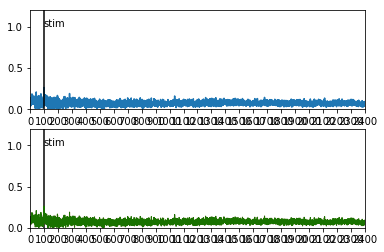

In [12]:
# Plotting - single sample 
def layout_plot(plot, tick_spacing=100, fov=(0, 2400, 0, 1.2), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

# Get rows where current event is active and draw a vertical 
# line to indicate the event in the plot
event_df = sample_df[sample_df.loc[:,ctc.get_event_start_col()] == 1]
fig = plt.figure()
fig.set_facecolor("white")

# Plot all cells from cell_subset_df over entire time (specified in Cell_Trace_Config).
sub1 = fig.add_subplot(211) #211
cell_subset_df.plot(ax=sub1)
ctc.add_event_time_points_to_plot(event_df, sub1)
layout_plot(sub1)

# Avg, min, max, std-dev for multiple cells in single sample over whole time
sub2 = fig.add_subplot(212)#212
ctc.add_event_time_points_to_plot(event_df, sub2)
cell_avg_df.plot(ax=sub2, color = 'g', label = ctc.cell_type, linewidth=1)
#cell_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#cell_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
cell_avg_df.plot.line(yerr=cell_std_df, ax=sub2, color = 'r', alpha = 0.1)
#cell_avg_df.plot.line(yerr=cell_sem_df, ax=sub2, color = 'c', alpha = 0.1)
layout_plot(sub2)


In [ ]:
# Note: HERE FOR PLOTTING THE ALIGNED EVENT, INDEPENDENT OF PRO AND / OR POST_EVENT
# Plotting for multi-events (all_df) (raw_dff_data)
# If a dataframe with NANs is plotted, use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=0.5, fov=(-20, 50, -0.05, 1.9), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
sub1 = fig.add_subplot(211)
all_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
aligned_layout_plot(sub1)

sub2 = fig.add_subplot(212)
all_cell_avg_df.plot(ax=sub2, color = 'k', label = ctc.cell_type) #use interpolated df to calculate average...
#all_cell_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_cell_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_cell_avg_df.plot.line(yerr=all_cell_std_df, ax=sub2, color = 'r', alpha = 0.1)
#all_cell_avg_df.plot.line(yerr=all_cell_sem_df, ax=sub2, color = 'c', alpha = 0.1)
aligned_layout_plot(sub2)


The following part extract the information about behavior transition under certain limitation:
1) Find transition between two different! behaviors, within a max_delay.
2) Find 2 transition between two different! behaviors with intersection: first event end = second event start, within a max_delay.
3) Find transition between two identical! behaviors, within a max_delay.

In [74]:
class PostBehaviorTransition:
        
    def __init__(self, sample_id, event, post_event, max_delay=0):
        self.sample_id = sample_id
        self.post_event = post_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_before(sample_id, sample_df, first_event, second_event, 
                         max_delay=0,
                         first_event_duration=None, 
                         second_event_duration=None):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that is followed by the event <second_event>,
    separated by <max_delay> time. The end of <second_event> is expected
    to happen strictly after the end of <first_event>. The start time
    of <second_event> however can overlap with the end time of <first_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The start time of <second_event> can be before, at or after the
    end of <first_event>.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
   
    for i, row in sample_df.iterrows():
        # Look for start of second behavior and remember its time.
        if row[second_event_start_col] and not row[second_event_overlap_col]:
            #print("{} starts at {}".format(second_event, row["time"]))
            second_event_start_time = row['time']
        if row[first_event_end_col]:
            #print("{} ends at {}".format(first_event, row["time"]))
            first_event_end_time = row['time']
        if row[first_event_start_col]:
            #print("{} starts at {}".format(first_event, row["time"]))
            first_event_start_time = row['time']
        for column in sample_df.columns:
            if (first_event_start_time is not None and
                column.endswith("_start") and
                "quiet" not in column and
                column != first_event_start_col and
                column != second_event_start_col and
                first_event not in column and
                second_event not in column):
                if row[column]:
                    #print("{} ended at {}, but then found {} at {}".format(first_event, first_event_end_time, column, row["time"]))
                    first_event_start_time = None
                    first_event_end_time = None
                    second_event_start_time = None
                    second_event_end_time = None
                    
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time):
            continue
        
        # Define rules for event_start_time and event_end_time
        if first_event_start_time > second_event_start_time:
            continue
        if first_event_start_time > first_event_end_time:
            continue
        
        # Test if first_event_start_time = second_event_start_time
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))
            
        if second_event_end_time is None:
            for j, row in sample_df.loc[i:, :].iterrows():
                if row[second_event_end_col]:
                    second_event_end_time = row["time"]
                    break
        if second_event_end_time is None:
            print("warning: end time not found for second event")

        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        # implement event duration (for quiet)
        if (second_event_start_time - first_event_end_time) <= max_delay:
            if first_event_duration is not None and first_event_end_time - first_event_start_time < first_event_duration:
                continue
            if second_event_duration is not None and second_event_end_time - second_event_start_time < second_event_duration:
                continue
            
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time,
                'first_event': first_event,
                'second_event': second_event
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
        
    return results

# Open single samples 

behavior_transitions = [
    PostBehaviorTransition('17-08-26L2-cl', 'fw', 'stim', 4.9)
#    PostBehaviorTransition('17-08-26L6-cl', 'turn', 'bw', 4.9)
]

# Open all samples single Transitions
#behavior_transitions = [
#    PostBehaviorTransition(name, 'stim', 'fw', 4.9) for name in lm_data]

'''
# Open all samples multiple Transitions
behavior_transitions = [
    PostBehaviorTransition(name, 'fw', 'stim', 4.9) for name in lm_data] + [
    PostBehaviorTransition(name, 'bw', 'stim', 4.9) for name in lm_data] + [
    PostBehaviorTransition(name, 'turn', 'stim', 4.9) for name in lm_data] + [
    PostBehaviorTransition(name, 'hunch', 'stim', 4.9) for name in lm_data] + [
    PostBehaviorTransition(name, 'other', 'stim', 4.9) for name in lm_data]
'''

found_transitions = []
for bt in tqdm(behavior_transitions):
    sample_df = sample_data.get(bt.sample_id)
    if not any(["bw" in column for column in sample_df.columns]):
        continue
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_before(bt.sample_id, sample_df, bt.event, 
                                       bt.post_event, bt.max_delay, 
                                       first_event_duration = None, 
                                       second_event_duration = None) #For 'quiet' change *_event_duration. Defaul = None.
    
    if transitions:
        found_transitions.append(transitions)


print(len(found_transitions)) # Number of data sets 
print(sum([len(sample_transitions) for sample_transitions in found_transitions])) # Number of transitions/ not working!!
#print(found_transitions) # Transitions


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

1
6


In [ ]:
# Duration between diff behavior from PostTransition (min, max, avg)
# Note: only works for one type of transitions
gap_Ptrans = []
for sample in found_transitions:
    for found_transition in sample:
        gap_Ptrans.append((found_transition["second_event_start"])-(found_transition["first_event_end"]))
        
        # Test minus valus
        if ((found_transition["second_event_start"])-(found_transition["first_event_end"])) < -4:
            print(bt.sample_id, found_transition["first_event_end"], found_transition["second_event_start"]) 
#print(gap_Ptrans)

avg_duration = np.mean(gap_Ptrans)
max_duration = np.max(gap_Ptrans)
min_duration = np.min(gap_Ptrans)

print(avg_duration)
print(max_duration)
print(min_duration)

# Histogram
fig = plt.figure()
plt.hist(gap_Ptrans, bins=100, alpha=0.5)
plt.show()

In [79]:
# Define celltype, filter-pattern for transitions. Optional do not run regex-filter. Aligning to first event start or 
# second event start: depends on stimulus. Output: a) aligned raw values, b) aloigned interpolated values.
# tqdm = progress bar

cell_Ptrans_configs = []
all_Ptrans_events = []


for sample in tqdm(found_transitions):
    for found_transition in sample:
        
        # For all behavior except stimulus as first event 
        cell_Ptrans_configs.append(CellTransConfig(found_transition["sample_id"], "basin",
                                                    found_transition["second_event_start"], 
                                                    filter_pattern = 'A1R', 
                                                    first_event=found_transition["first_event"], 
                                                    second_event=found_transition["second_event"]))
        
        # For stimulus as first_event
        #cell_Ptrans_configs.append(CellTransConfig(found_transition["sample_id"], "basin", 
        #                                           found_transition["first_event_start"], 'A6', 
        #                                           first_event=found_transition["first_event"], 
        #                                           second_event=found_transition["second_event"]))

# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_df). 
# This works for single sample or multiple samples aligned 
# Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
# Add index and time = column

# Set the window range left and right from the event (in seconds)
left_half_window_size = 18.5 # If negative it goes further to right half (Good for skipping stimulus)
right_half_window_size = 42.4

# trans_df defined in pargraph before 
windows = []
n_behavior = 0

for ctc in tqdm(cell_Ptrans_configs):
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
   
    # Extract columns matching our cell type and the optional filter pattern.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    
    # Don't apply filter regex, but take all cells from lm_data --> this does not work!
    # ToDo
    #cell_subset_df = lm_data.get(ctc.sample_id)#Get subset of cells 
    #cell_subset_df.reset_index(inplace = True, drop = True) # Add index and time = column
    
    n_behavior += 1
    window_start = ctc.event_time - left_half_window_size
    window_end = ctc.event_time + right_half_window_size
        
    # Get subset of rows between window_start and window_end
    # Including event_start
    #trans = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
    # Excluding event start
    trans = cell_subset_df[(cell_subset_df.time > window_start) & (cell_subset_df.time < window_end)]
    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    #trans.loc[:, 'time'] = trans['time'] - row['time']
    trans.loc[:, 'time'] = trans['time'] - ctc.event_time
    
    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    trans.rename(lambda x: '{}_{}_{}_{}_{}'.format(ctc.sample_id, x, n_behavior, ctc.first_event, ctc.second_event), axis = 'columns', inplace = True) 

    # Rename time collum to time
    trans.rename(columns={ trans.columns[0]: 'time' }, inplace = True) 
    all_Ptrans_events.append(trans) # Append a list with all event
#print(all_Ptrans_events)

# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_Ptrans_df = all_Ptrans_events.pop(0)
for right_df in all_Ptrans_events:
    all_Ptrans_df = pd.merge_ordered(all_Ptrans_df, right_df, on="time", how="outer")
#print(all_Ptrans_df)

# Resets the index as time and drops time column
all_Ptrans_df.index = all_Ptrans_df["time"]
del all_Ptrans_df["time"]        
#print(all_Ptrans_df)

# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_Ptrans_df = all_Ptrans_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_Ptrans_df.columns)

100%|██████████| 6/6 [00:00<00:00,  7.74it/s]


In [ ]:
# Figure out how many cells of a determine type and filter pattern are involved in a specific transition
def extract_parts(column:str, indicies):
    parts = column.split("_")
    return tuple(parts[i] for i in indicies)
# indicies: 0: sample_id, 1: cell, 2: filter_pattern, 3: n_obs, 4: first_event, 5:second_event
parts = [extract_parts(column, [0,1,2]) for column in int_all_Ptrans_df.columns]
print(len(parts))
print(len(set(parts)))
#print(set(parts))

In [ ]:
# For multiple transition events, group after transition (first, or second event) <most useful> with option to group
# after celltype, filterpattern, sample_id, observations, using class TransitionType

transition_types = [
    #TransitionType(first_event = 'fw'),
    #TransitionType(first_event = 'bw'),
    #TransitionType(first_event = 'turn'),
    #TransitionType(first_event = 'hunch'),
    #TransitionType(first_event = 'other'),
    TransitionType(first_event = 'stim')
]

print(transition_types)

['cyan', 'red', 'violet', 'red', 'blue']


<IPython.core.display.Javascript object>


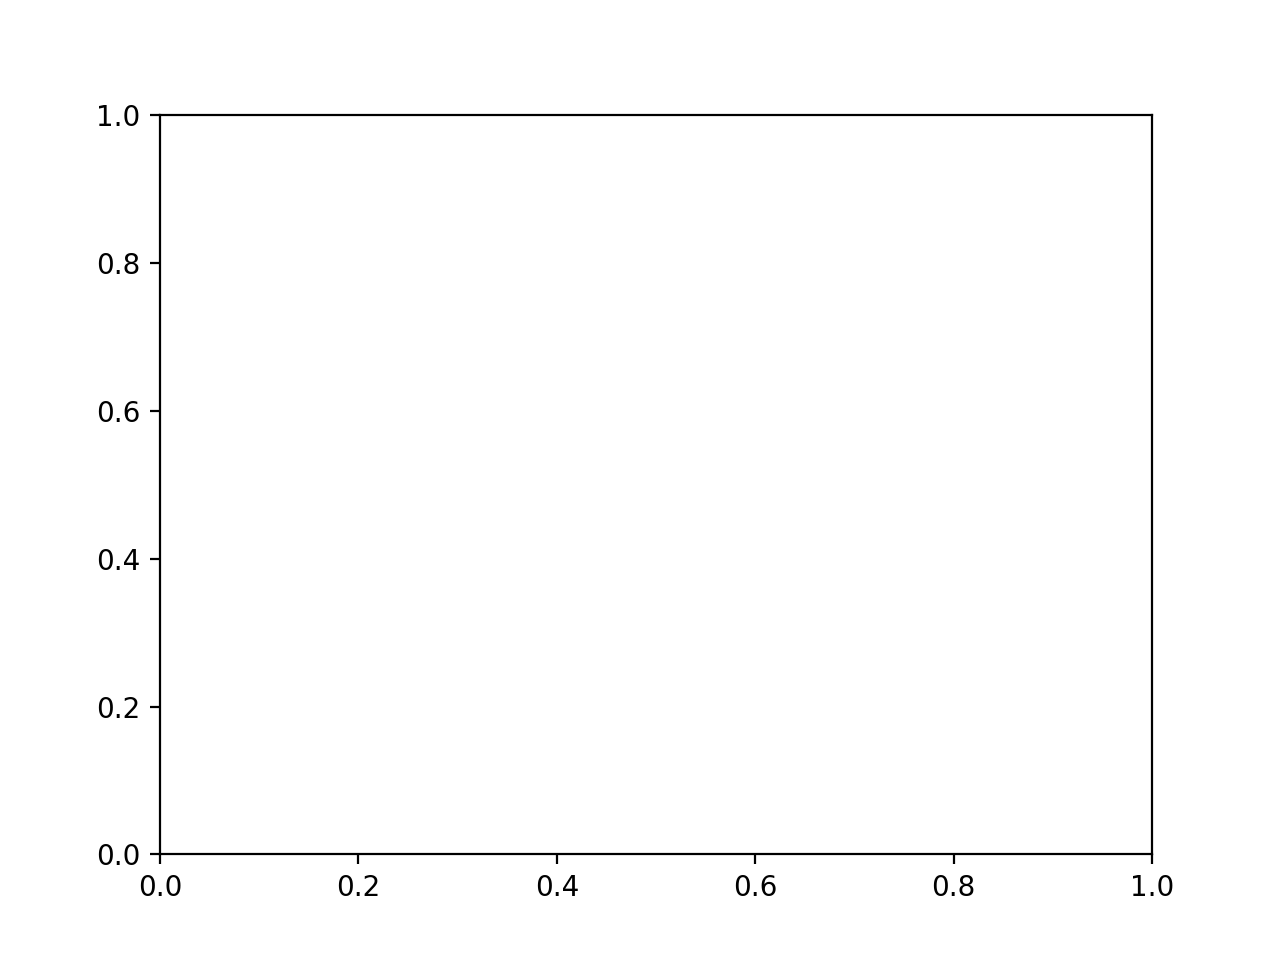

NameError: name 'transition_types' is not defined

In [82]:
%matplotlib notebook 

# For multiple transition types!! 
# If a dataframe with NANs is plotted (raw-data = non interpolated), use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=5, fov=(-18.5, 42.4, 0.0, 1.0), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

colors = ["cyan", "red", "violet", "red", "blue"]
# colors = {tt.get_filter_regex(use_cell=True, use_filter_pattern=True, use_first_event=True, use_second_event=True) : color for tt, color in zip(transition_types, colors)}
    
print(colors)
    
fig = plt.figure()
sub2 = fig.add_subplot(111) 
for tt, color in zip(transition_types, colors):
    int_some_Ptrans_df = int_all_Ptrans_df.filter(regex=tt.get_filter_regex(use_cell=True, use_filter_pattern=True, use_first_event=True, use_second_event=True))

    # Average and stddev, min, max, sem for post_behavior_transition events
    all_Ptrans_avg_df = int_some_Ptrans_df.mean(axis=1) # Interpolated data used
    all_Ptrans_min_df = int_some_Ptrans_df.min(axis=1)
    all_Ptrans_max_df = int_some_Ptrans_df.max(axis=1)
    # Standard deviation (distribution)
    all_Ptrans_std_df = int_some_Ptrans_df.std(axis = 1)
    #standard error of mean
    all_Ptrans_sem_df = int_some_Ptrans_df.sem(axis = 1)

    all_Ptrans_avg_df.plot(ax=sub2, label = tt.get_filter_regex(use_all=True), color = color) #use interpolated df to calculate average...
    #all_Ptrans_avg_df.plot(yerr=all_Ptrans_std_df, ax=sub2, label = tt.get_filter_regex(use_all=True), alpha = 0.005, color = color)
    all_Ptrans_avg_df.plot.line(yerr=all_Ptrans_sem_df, ax=sub2, color = 'grey', alpha = 0.5)
aligned_layout_plot(sub2, legend=True)


<IPython.core.display.Javascript object>


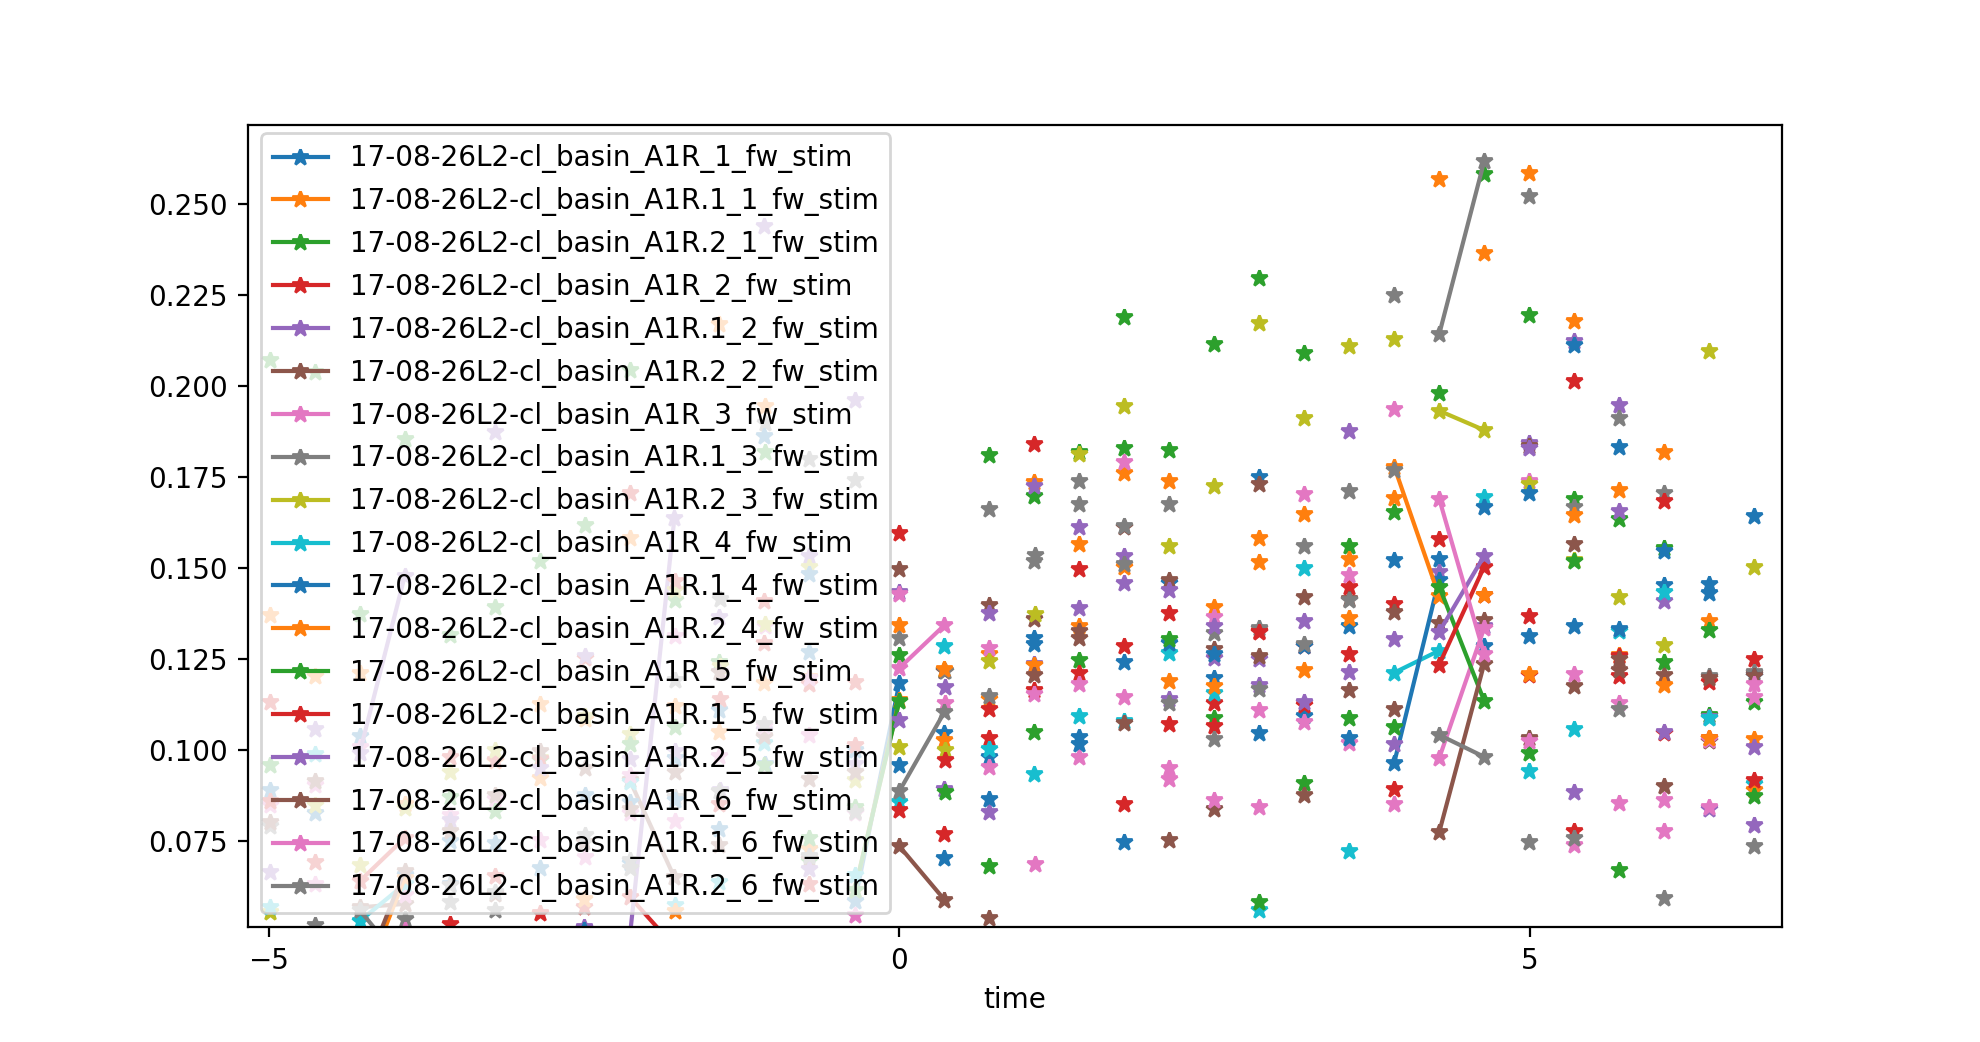

In [83]:
# To make the plot in the notebook and not in an extra window
%matplotlib notebook 

# Only for one type of transitions (I still need this!!)

# Average and stddev, min, max, sem for post_behavior_transition events
all_Ptrans_avg_df = int_all_Ptrans_df.mean(axis=1) # Interpolated data used
all_Ptrans_min_df = int_all_Ptrans_df.min(axis=1)
all_Ptrans_max_df = int_all_Ptrans_df.max(axis=1)
# Standard deviation (distribution)
all_Ptrans_std_df = int_all_Ptrans_df.std(axis = 1)
#standard error of mean
all_Ptrans_sem_df = int_all_Ptrans_df.sem(axis = 1)
#wrong zur haelfte: Want to have avg per celltyp over time point, 
#and not avg over all cells per timepoint (refer to Data_filter or Grouper) 

# Plotting for multi-events (same_behavioral_transition)
# If a dataframe with NANs is plotted (raw-data = non interpolated), use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=5, fov=(-18.5, 42.4, 0.0, 1.0), legend=True): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
sub1 = fig.add_subplot(111) #211
all_Ptrans_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
aligned_layout_plot(sub1)

#sub2 = fig.add_subplot(212) #212
#all_Ptrans_avg_df.plot(ax=sub2, color = 'c', label = ctc.cell_type) #use interpolated df to calculate average...
#all_Ptrans_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_Ptrans_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_Ptrans_avg_df.plot.line(yerr=all_Ptrans_std_df, ax=sub2, color = 'lightgrey', alpha = 0.1)
#all_Ptrans_avg_df.plot.line(yerr=all_Ptrans_sem_df, ax=sub2, color = 'grey', alpha = 0.1)
#aligned_layout_plot(sub2)


In [ ]:
# all all_Ptrans_df with left and right window in same data frame and aligned to second_event_start 
#(for stim first event on first_event_start_)
# Average over the frames within the same sample (eg average over 1 sec)
# extract all negative values for pre_event
# extract positiv values for post event, but in case of the stimulus, the first two seconds must not be included


pre_data = all_Ptrans_df[all_Ptrans_df.index < 0.0]
post_data = all_Ptrans_df[all_Ptrans_df.index > 2.0] # for stim-behavior >2, otherwise >=0

int_pre_data = pre_data.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
int_post_data = post_data.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')

# Average over time for each cell type
pre_data_avg = pre_data.mean(axis = 0)
post_data_avg = post_data.mean(axis = 0)


In [ ]:
# Fold change (bar plot) in cell activity post - pre/pre (merged orderd,No interpolation, NO avg)
# Fold change for all cells individually

# fold changeI: post/pre
#fold_change = (post_data_avg)/(pre_data_avg) 

# fold changeII: post-pre/pre
fold_change = ((post_data_avg)-(pre_data_avg))/(pre_data_avg)
#print(fold_change.index)

# Transform Series to dataframe and name columns
fold_change_df = fold_change.to_frame('transitions')
# print(fold_change_df.index)
# transitions = set(["_".join(sample_transition.split("_")[-2:]) for sample_transition in fold_change_df.index])

transitions = []
past = None
for sample_transition in fold_change_df.index:
    current = "_".join(sample_transition.split("_")[-2:])
    if current != past:
        transitions.append(current)
        past = current
print(transitions)

print(transitions)
transition_df_map = {transition: fold_change_df[fold_change_df.index.str.contains(transition)] for transition in transitions}
print(list(transition_df_map.keys()))
#print(transition_df_map["fw_stim"].head(10))




In [ ]:
# Merge
# df_key = name, df-list = dataframe
transition_df_list = list(transition_df_map.items())
df_key, all_fold_change_df = transition_df_list.pop(0)
for df_key, right_df in transition_df_list:
    all_fold_change_df = pd.merge(
        all_fold_change_df, right_df, left_index=True, right_index=True, how="outer"
    )

#print(all_fold_change_df.to_string()) #print everything

# Plot fold change
ax = all_fold_change_df.plot.box() # its a series (diff for data frame)
ax.set_title('')
ax.set_xlabel('Transitions')
ax.set_ylabel('Fold change')
ax.set_xticklabels(list(transition_df_map.keys()))

#ax = fold_change_df.plot.box() #single transition type
plt.show()


In [ ]:
# Mann-Witney U test (non-parametric pair wise test)

# da ist ne Menge significant:()

from scipy.stats import stats
from scipy.stats import mannwhitneyu

#mwu1 = mannwhitneyu(transition_df_map["fw_stim"], transition_df_map["bw_stim"])
#mwu2 = mannwhitneyu(transition_df_map["fw_stim"], transition_df_map["turn_stim"])
#mwu3 = mannwhitneyu(transition_df_map["fw_stim"], transition_df_map["hunch_stim"])
#mwu4 = mannwhitneyu(transition_df_map["fw_stim"], transition_df_map["other_stim"])
#mwu5 = mannwhitneyu(transition_df_map["bw_stim"], transition_df_map["turn_stim"])
#mwu6 = mannwhitneyu(transition_df_map["bw_stim"], transition_df_map["bw_stim"])

#print(mwu1, mwu2, mwu3, mwu4, mwu5, mwu6)
#print(mwu1)

In [ ]:
# Triple transition
# Find first and  second transition between two different! behaviors with intersection: 
# first event end = second event start, within a max_delay.
 
# Open single samples 
'''
first_transitions = [
    PostBehaviorTransition('17-08-26L6-cl', 'fw', 'stim', 3)
]
second_transitions = [
    PostBehaviorTransition('17-08-26L6-cl', 'stim', 'fw', 3)
]
'''
# Open all samples

first_transitions = [
    PostBehaviorTransition(name,'bw', 'stim', 3) for name in lm_data]
    
second_transitions = [
    PostBehaviorTransition(name,'stim', 'quiet', 3) for name in lm_data]    


found_transitions = []
for first_bt, second_bt in tqdm(zip(first_transitions, second_transitions)):
    transitions=[]
    assert first_bt.sample_id == second_bt.sample_id, "{} does not match {}".format(first_bt.sample_id, second_bt.sample_id)
    sample_df = sample_data.get(first_bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    if not any(["bw" in column for column in sample_df.columns]):
        continue
    first_transition_duration = None
    second_transition_duration = None
    third_transition_duration = 2
    first_transitions = find_behavior_before(first_bt.sample_id, sample_df, first_bt.event, first_bt.post_event, first_bt.max_delay, first_event_duration=first_transition_duration, 
                         second_event_duration=second_transition_duration)
    second_transitions = find_behavior_before(second_bt.sample_id, sample_df, second_bt.event, second_bt.post_event, second_bt.max_delay, first_event_duration=second_transition_duration, 
                         second_event_duration=third_transition_duration)
    #print("{} transitions from {} to {}".format(len(first_transitions), first_bt.event, first_bt.post_event))
    #print("{} transitions from {} to {}".format(len(second_transitions), second_bt.event, second_bt.post_event))
    
    for ft in first_transitions:
        for st in second_transitions:
            if abs(ft["second_event_start"] - st["first_event_start"]) < 0.00001:
                transitions.append({
                    "sample_id":ft["sample_id"], "first_event_start":ft["first_event_start"], "first_event_end":ft["first_event_end"],
                    "second_event_start": st["first_event_start"], "second_event_end": st["first_event_end"],
                    "third_event_start": st["second_event_start"]
                })
    if transitions:
        print("{} transition triples found".format(len(transitions)))
        found_transitions.append(transitions)
    


print(len(found_transitions)) #number of data sets not the actual stim
print(sum([len(sample_transitions) for sample_transitions in found_transitions]))
print(found_transitions)

In [ ]:
# Use the predefined CellTransConfig to filter by celltype and pattern.
# The results are merged_ordered and interpolated.
cell_Ttrans_configs = []
all_Ttrans_events = []

for sample in tqdm(found_transitions):
    sample_ls_trans = []
    for found_transition in sample:
        
        # For all behavior
        sample_ls_trans.append(found_transition["second_event_start"]) 
        cell_Ttrans_configs.append(CellTransConfig(found_transition["sample_id"], "A00c", 
                                                  found_transition["second_event_start"]))

# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_df). 
# This works for single sample or multiple samples aligned 
# Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
# Add index and time = column

# Set the window range left and right from the event (in seconds)
left_half_window_size = 100.0 
right_half_window_size = 200.0

# trans_df defined in pargraph before 
windows = []
n_behavior = 0

for ctc in tqdm(cell_Ttrans_configs):
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(cell_subset_df)
    
    # Don't apply filter regex, but take all cells from lm_data
    #cell_subset_df =  lm_data.get(ctc.sample_id)#Get subset of cells 
    #cell_subset_df.reset_index(inplace = True, drop = True) # Add index and time = column
    #print(cell_subset_df)
    
    n_behavior += 1
    window_start = ctc.event_time - left_half_window_size
    window_end = ctc.event_time + right_half_window_size
        
    # Get subset of rows between window_start and window_end       
    trans = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    #trans.loc[:, 'time'] = trans['time'] - row['time']
    trans.loc[:, 'time'] = trans['time'] - ctc.event_time
    
    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    trans.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), axis = 'columns', inplace = True) 

    # Rename time collum to time
    trans.rename(columns={ trans.columns[0]: 'time' }, inplace = True) 
    all_Ttrans_events.append(trans) # Append a list with all event
      
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_Ttrans_df = all_Ttrans_events.pop(0)
for right_df in all_Ttrans_events:
    all_Ttrans_df = pd.merge_ordered(all_Ttrans_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column
all_Ttrans_df.index = all_Ttrans_df["time"]
del all_Ttrans_df["time"]        
#print(all_Ttrans_df)

# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_Ttrans_df = all_Ttrans_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_Ttrans_df)


In [ ]:
# Average and stddev, min, max, sem for post_behavior_transition events
all_Ttrans_avg_df = int_all_Ttrans_df.mean(axis=1) # Interpolated data used
all_Ttrans_min_df = int_all_Ttrans_df.min(axis=1)
all_Ttrans_max_df = int_all_Ttrans_df.max(axis=1)
# Standard deviation (distribution)
all_Ttrans_std_df = int_all_Ttrans_df.std(axis = 1)
#standard error of mean
all_Ttrans_sem_df = int_all_Ttrans_df.sem(axis = 1)
#wrong zur haelfte: Want to have avg per celltyp over time point, 
#and not avg over all cells per timepoint

# Plotting for multi-events (same_behavioral_transition)
# If a dataframe with NANs is plotted (raw-data = non interpolated), use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=10, fov=(-20, 50, 0.0, 1.0), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
#sub1 = fig.add_subplot(211)
#all_Ttrans_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
#aligned_layout_plot(sub1)

sub2 = fig.add_subplot(111) #212
all_Ttrans_avg_df.plot(ax=sub2, color = 'r', label = ctc.cell_type) #use interpolated df to calculate average...
#all_Ttrans_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_Ttrans_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_Ttrans_avg_df.plot.line(yerr=all_Ttrans_std_df, ax=sub2, color = 'lightgrey', alpha = 0.1)
#all_Ttrans_avg_df.plot.line(yerr=all_Ttrans_sem_df, ax=sub2, color = 'grey', alpha = 0.1)
aligned_layout_plot(sub2)

In [ ]:
# Behavior_transitions for identical behavior type

class SamePairBehaviorTransition:
    
    def __init__(self, sample_id, pre_event, event, max_delay=0, max_ignored_quiet_time=math.inf):
        self.sample_id = sample_id
        self.pre_event = pre_event
        self.event = event
        self.max_delay = max_delay
        self.max_ignored_quiet_time = max_ignored_quiet_time

print("finding same behaviors only")
def find_behavior_next(sample_id, sample_df, first_event, second_event, max_delay=0,
                       max_ignored_quiet_time=math.inf):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that will be followed by the same event <second_event>,
    separated by <max_delay> time. The start of <first_event> is expected
    to happen strictly before the start of <second_event>. The end time
    of <first_event> however can overlap with the start time of <second_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The end time of <first_event> can be before, at or after the
    end of <second_event>.
    
    If <first_event> and <second_event> are the same type of behavior,
    overlaps have to be taken into account differently to match start and end times
    to the correct event. During iteration for one loop, we have to exclude the 
    fact that the first_event == second_event.
    
    Assumption: No overlapp
    Not in data sets identified
    """
    
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    first_event_overlap_col = '{}_overlap'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event)
    
    # Construct a list without quiet and passed in behaviors
    other_behavior_cols = get_unrelated_nonquiet_behaviors((first_event, second_event))
    other_behavior_start_cols = ['{}_start'.format(c) for c in other_behavior_cols]
    
    first_event_start_time = None
    first_event_end_time = None
    quiet_event_start_time = None
    quiet_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    # Check for overlap between the same behaviors (print index, where 'True') and use
    # it as a check that there is not this error in the behavior data
    ##print(sample_id, sample_df.index[sample_df['bw_overlap']].tolist())
    
    # Note: The overlap statement was removed. This part has to be 
    # checked if overlapping events are found in the data
    for i, row in sample_df.iterrows():
        # Look for start of first behavior and remember its time.
        if row[first_event_start_col]and first_event_start_time is None:
            first_event_start_time = row['time']
        if row[first_event_end_col] and first_event_end_time is None: 
            first_event_end_time = row['time']
        if row[second_event_start_col] and first_event_start_time is not None:
            second_event_start_time = row['time']
        if row[second_event_end_col] and first_event_end_time is not None:
            second_event_end_time = row['time']
 
        if first_event_start_time:
            if row['quiet_start']:
                quiet_event_start_time = row['time']
            elif quiet_event_start_time is not None and row['quiet_end']:
                quiet_event_end_time = row['time']
    
            reset = False
        
            # If we found a quiet start and end time *after* the start of
            # the first event has been found, reset pattern search if the
            # quiet period is larger than max_ignored_quiet_time.
            if quiet_event_start_time is not None and \
                    quiet_event_end_time is not None:
                quiet_duration = quiet_event_end_time - quiet_event_start_time
                if quiet_duration > max_ignored_quiet_time:
                    reset = True
                
            # If any non-quiet and non-passed-in behavior is start
            if any(row[c] for c in other_behavior_start_cols):
                reset = True
                
            if reset:
                first_event_start_time = None
                first_event_end_time = None
                quiet_event_start_time = None
                quiet_event_end_time = None
                second_event_start_time = None
                second_event_end_time = None
            
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time, second_event_end_time):
            continue
        
        
        if first_event_start_time == second_event_start_time:
            continue
        if first_event_end_time == second_event_end_time:
            continue
        if first_event_start_time > first_event_end_time:
            continue
        if first_event_start_time > second_event_start_time:
            continue

        
        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed. During iteration the first_event == second_event. 
        if (second_event_start_time == first_event_end_time): #NR
            continue
        if (second_event_start_time - first_event_end_time) <= max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = second_event_start_time
        first_event_end_time = second_event_end_time
        second_event_start_time = None
        second_event_end_time = None
        quiet_event_start_time = None
        quiet_event_end_time = None
            
    return results


def get_unrelated_nonquiet_behaviors(excluding=[]):
    if 'turn' in excluding:
        turn_behaviors = ['left turn', 'right turn']
        turn_behaviors.extend(excluding)
        excluding = turn_behaviors
    return [ab for ab in available_behaviors if ab not in excluding]    

# Open single sample

#behavior_transitions = [
#    SamePairBehaviorTransition('17-08-26L1-cl', 'turn', 'turn', max_delay=10, max_ignored_quiet_time = math.inf)
    #SamePairBehaviorTransition('17-08-24L1-cl', 'fw', 'fw', max_delay=10, max_ignored_quiet_time = math.inf)
    #SamePairBehaviorTransition('17-11-06L3-cl', 'bw', 'bw', 3),
    #SamePairBehaviorTransition('17-11-29L1-cl', 'bw', 'bw', 3)
#]


# Open all samples 
behavior_transitions = [
    SamePairBehaviorTransition(name, 'turn', 'turn', max_delay=10, max_ignored_quiet_time = math.inf) for name in lm_data]


found_transitions = []
for bt in tqdm(behavior_transitions):
    sample_df = sample_data.get(bt.sample_id)
    
    if not any(["bw" in column for column in sample_df.columns]):
        continue
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_next(bt.sample_id, sample_df, bt.pre_event,
                                     bt.event, bt.max_delay, bt.max_ignored_quiet_time)

    if transitions:
        found_transitions.append(transitions)

#print(len(transitions))
print(len(found_transitions))
print(sum([len(sample_transitions) for sample_transitions in found_transitions]))
#print(found_transitions)


In [ ]:
# Duration between behavior from SameTransition (min, max, avg)
gap_Strans = []
for sample in tqdm(found_transitions):
    for found_transition in sample:
        gap_Strans.append((found_transition["second_event_start"])-(found_transition["first_event_end"]))
        
        if ((found_transition["second_event_start"])-(found_transition["first_event_end"])) < -5:
            print(bt.sample_id, found_transition["first_event_end"], found_transition["second_event_start"]) 
#print(gap_Strans)

avg_duration = np.mean(gap_Strans)
max_duration = np.max(gap_Strans)
min_duration = np.min(gap_Strans)

print(avg_duration)
print(max_duration)
print(min_duration)

# Histogram (doesnt show everything)
plt.hist(gap_Strans, bins=100, alpha=0.5)
plt.show()

###there is always the same timestamp and -7.354

In [ ]:
# For same_behavior_transition events get event_time and use cell_trace_config to filter by celltype and pattern.
# The results are merged and interpolated.
cell_Strans_configs = []
all_Strans_events = []

for sample in tqdm(found_transitions):
    sample_ls_trans = []
    for found_transition in sample:
        #print(found_transition["sample_id"], found_transition["second_event_start"])
        #print(found_transition["first_event_end"])
        # Sustitute cell_type with None if you don"t want to sort
        sample_ls_trans.append(found_transition["second_event_start"])
        cell_Strans_configs.append(CellTransConfig(found_transition["sample_id"], 'A00c', 
                                                  found_transition["second_event_start"], 'mid' ))

# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_df). 
# This works for single sample or multiple samples aligned 
# Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
# Add index and time = column

# Set the window range left and right from the event
left_half_window_size = 20.0 #in seconds
right_half_window_size = 50.0

# trans_df defined in pargraph before 
windows = []
n_behavior = 0

for ctc in tqdm(cell_Strans_configs):
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    # Apply filter regex 
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(cell_subset_df)
    
    # Don't apply filter regex, but take all cells from lm_data
    #cell_subset_df =  lm_data.get(ctc.sample_id)#Get subset of cells  (includes column with sample_id and exp_id)
    #cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    #cell_subset_df.reset_index(inplace = True, drop = True) # Add index and time = column
    #if 'time' not in cell_subset_df:
    #    print("ignoring " + ctc.sample_id)
    #    continue
    #else:
    #    print("processing " + ctc.sample_id)
    #print(cell_subset_df['time'])
    
    n_behavior += 1
    window_start = ctc.event_time - left_half_window_size
    window_end = ctc.event_time + right_half_window_size
        
    # Get subset of rows between window_start and window_end       
    trans = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
    #print(trans)
    #print(trans['time'])
    #print(trans.loc[:,'time'])
    #print(trans['time']- ctc.event_time)
    
    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    #trans.loc[:, 'time'] = trans['time'] - row['time']
    #trans.loc[:, 'time'] = trans['time'] - ctc.event_time # Works after applying filer
    trans.loc[:, 'time'] = trans['time'] - ctc.event_time
    
    
    
    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    trans.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), axis = 'columns', inplace = True) 

    # Rename time collum to time
    trans.rename(columns={ trans.columns[0]: 'time' }, inplace = True) 
    all_Strans_events.append(trans) # Append a list with all event
    #print(trans)    
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_Strans_df = all_Strans_events.pop(0)
for right_df in all_Strans_events:
    all_Strans_df = pd.merge_ordered(all_Strans_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column (sollte spaeter kommen)
all_Strans_df.index = all_Strans_df["time"]
del all_Strans_df["time"]        
#print(all_Strans_df)

# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_Strans_df = all_Strans_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_Strans_df)

In [ ]:
# Average and stddev, min, max, sem for same_behavior_transition events
all_Strans_avg_df = int_all_Strans_df.mean(axis=1) # Interpolated data used
all_Strans_min_df = int_all_Strans_df.min(axis=1)
all_Strans_max_df = int_all_Strans_df.max(axis=1)
# Standard deviation (distribution)
all_Strans_std_df = int_all_Strans_df.std(axis = 1)
#standard error of mean
all_Strans_sem_df = int_all_Strans_df.sem(axis = 1)
#wrong zur haelfte: Want to have avg per celltyp over time point, 
#and not avg over all cells per timepoint --> should work with transition-grouper

# Plotting for multi-events (same_behavioral_transition)
# If a dataframe with NANs is plotted (raw-data = non interpolated), use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=1, fov=(-10, 10, 0.0, 0.2), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
#sub1 = fig.add_subplot(111) #211
#all_trans_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
#aligned_layout_plot(sub1)

sub2 = fig.add_subplot(111) #212
all_Strans_avg_df.plot(ax=sub2, color = 'r', label = ctc.cell_type) #use interpolated df to calculate average...
#all_Strans_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_Strans_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_Strans_avg_df.plot.line(yerr=all_Strans_std_df, ax=sub2, color = 'lightgrey', alpha = 0.5)
#all_Strans_avg_df.plot.line(yerr=all_Strans_sem_df, ax=sub2, color = 'grey', alpha = 0.1)
aligned_layout_plot(sub2)

In [ ]:
# Using class Transitiongrouper to group cell_type/pattern or both
# This is crucial if statistical methods are applied for sub groups
# Input dataframe from behavioral transitions (Post-, Same-, Triple-Transition)

#grouper = TransitionGrouper(int_all_Ptrans_df)
grouper = TransitionGrouper(int_post_data)

# Function to calculate the average cell/pattern_groups depending on regex
def average_grouping(grouping):
    df = grouping[list(grouping)[0]][1]
    average_df = pd.DataFrame(index=df.index)
    
    for group_pattern, df in grouping.values():
        average_col = df.mean(axis=1)
        average_df[group_pattern] = average_col

    return average_df

# Function to calculate the std cell/pattern_groups depending on regex
def std_grouping(grouping):
    df = grouping[list(grouping)[0]][1]
    std_df = pd.DataFrame(index=df.index)
    
    for group_pattern, df in grouping.values():
        std_col = df.std(axis=1)
        std_df[group_pattern] = std_col

    return std_df

# Function to calculate the sem cell/pattern_groups depending on regex
def sem_grouping(grouping):
    df = grouping[list(grouping)[0]][1]
    sem_df = pd.DataFrame(index=df.index)
    
    for group_pattern, df in grouping.values():
        sem_col = df.sem(axis=1)
        sem_df[group_pattern] = sem_col

    return sem_df
    
    
cell_groups = grouper.group_cells()
cell_averages = average_grouping(cell_groups)
cell_std = std_grouping(cell_groups)
cell_sem = sem_grouping(cell_groups)
#print(cell_averages.head())

pattern_groups = grouper.group_patterns()
pattern_averages = average_grouping(pattern_groups) 
pattern_std = std_grouping(pattern_groups)
pattern_sem = sem_grouping(pattern_groups)
#print(pattern_averages.head())

cellpattern_groups = grouper.group_cellpattern()
cellpattern_averages = average_grouping(cellpattern_groups) 
cellpattern_std = std_grouping(cellpattern_groups)
cellpattern_sem = sem_grouping(cellpattern_groups)
#print(pattern_averages)


In [ ]:
# Plot average, std-dev from Transition grouper

def aligned_layout_plot(plot, tick_spacing=1, fov=(-10, 10, 0.0, 0.9), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

sub1 = fig.add_subplot(211)
pattern_averages.plot(ax=sub1)
aligned_layout_plot(sub1)

sub2 = fig.add_subplot(212)
cell_averages.plot(ax=sub2, color = 'r')
#cell_averages.plot(ax=sub2, yerr=cell_std, color = 'lightgrey', alpha = 0.1)
cell_averages.plot(ax=sub2, yerr=cell_sem, color = 'grey', alpha = 0.5)
aligned_layout_plot(sub2)


In [ ]:
# Duration of each behavior (min, max, avg)

desired_behavior = "hunch"
all_durations = []
sample_ids = []
start_times = []
end_times = []
for sample_id, sample_df in tqdm(sample_data.items()):
    if any(["bw" in column for column in sample_df.columns]):
        for i, row in sample_df.iterrows():
            if row["{}_start".format(desired_behavior)]:  
                start_times.append(row["time"])
                sample_ids.append(sample_id)
            if row["{}_end".format(desired_behavior)]: 
                end_time = row["time"]
                end_times.append(row["time"])
        assert len(end_times) == len(start_times), "{} start times vs {} end times on sample {}".format(len(start_times), len(end_times), sample_id)
all_durations = [end - start for start, end in zip(start_times, end_times)]
durations_with_sample_id = list(zip(sample_ids, all_durations))

# Test if behavior.csv is correct
for t, sample_id, start_time, end_time in zip(all_durations, sample_ids, start_times, end_times):
    if t > 200:
        print(sample_id, start_time, end_time)

#print(durations_with_sample_id[0:10])

#print(all_durations)       
#print(len(all_durations))
avg_duration = np.mean(all_durations)
max_duration = np.max(all_durations)
min_duration = np.min(all_durations)

print(avg_duration)
#print(max_duration)
#print(min_duration)

# Histogram
fig = plt.figure()
plt.hist(all_durations, bins=5, alpha=0.5)
plt.show()

#print(list(filter(lambda x: x> 10, all_durations)))  # not working

In [ ]:
# Neuronal activity of a certain behavior (all behavior from the same type, independent on pre- and post-event)

# For all behavior events (same type) get event_time and use cell_trace_config to filter by celltype and pattern.

# The results are merged and interpolated.

cell = "A00c" 
#pattern = 'mid'
desired_behavior = "fw"
align_to_start = True

sample_ids = []
start_times = []
end_times = []
desired_traces = []

# Checkpoint if not all behavior data are used for analysis, but dff and timestamps are available
for sample_id, sample_df in tqdm(sample_data.items()):
    if any(["bw" in column for column in sample_df.columns]):
        for i, row in sample_df.iterrows():
            if row["{}_start".format(desired_behavior)]:  
                start_times.append(row["time"])
                sample_ids.append(sample_id)
            if row["{}_end".format(desired_behavior)]: 
                end_time = row["time"]
                end_times.append(row["time"])
        assert len(end_times) == len(start_times), "{} start times vs {} end times on sample {}".format(len(start_times), len(end_times), sample_id)

for sample_id, start_time, end_time in zip(sample_ids, start_times, end_times):
    if align_to_start:
        desired_traces.append(CellTransConfig(sample_id, cell,
                                              start_time))
    else:
        desired_traces.append(CellTransConfig(sample_id, cell, 
                                              end_time))
        
print(len(desired_traces))

In [ ]:
# For testing if samples are different from each other, extract per sample the peak of each behavior wave (eg fw),
# for each A00c, each hemisegment for Basin and each segment for handles

cell = "A00c" #Note: for each cell type we need a specific grouping because of missing identity
pattern = 'postR'
desired_behavior = "fw"

sample_ids = []
peak_values = []
start_times = []
start_index = []
end_times = []
end_index = []

# Checkpoint if not all behavior data are used for analysis, but dff and timestamps are available
for sample_id, sample_df in tqdm(sample_data.items()):
    if any(["bw" in column for column in sample_df.columns]):
        for i, row in sample_df.iterrows():
            if row["{}_start".format(desired_behavior)]:  
                start_times.append(row["time"])
                start_index.append(i)
                sample_ids.append(sample_id)
            if row["{}_end".format(desired_behavior)]: 
                end_time = row["time"]
                end_index.append(i)
                end_times.append(row["time"])
        assert len(end_times) == len(start_times), "{} start times vs {} end times on sample {}".format(len(start_times), len(end_times), sample_id)
        
        
max_values = {}
for sample_id, start_time, end_time in zip(sample_ids, start_index, end_index):
    max_values.setdefault(sample_id, [])
    regex_pattern = "{}_{}".format(cell, pattern)
    sample_df = sample_data.get(sample_id)
    max_values[sample_id].append(sample_df.filter(like=regex_pattern, axis=1).loc[start_time:end_time].max().mean())
    
print({key: len(values) for key, values in max_values.items()})
print(max_values)
        

In [ ]:
from vnc_stats_python.hypothesis_tests.permutation_tests import all_pairs_perm_tests

# Pull out max values for each sample, taking care to throw out any nan values
smp_labels = list(max_values.keys())
n_smps = len(smp_labels)
smp_max_vls = [None]*n_smps
for i, s_l in enumerate(smp_labels):
    vls = np.asarray(max_values[s_l])
    vls = vls[np.logical_not(np.isnan(vls))] # Get rid of nan values
    smp_max_vls[i] = vls
    
    
# Now we want to get rid of any samples where we had *no* data (after removing nan values)
good_inds = [len(v) != 0 for v in smp_max_vls]
smp_labels = [s_l for i, sl in enumerate(smp_labels) if good_inds[i]]
smp_max_vls = [vl for i, vl in enumerate(smp_max_vls) if good_inds[i]]
    
p_vls = all_pairs_perm_tests(smp_max_vls, test_opts={'n_perms': 10000}, update_int=100)

In [ ]:
plt.imshow(p_vls < .01)
#plt.colorbar()

In [ ]:
print(p_vls)

In [ ]:
# Correlation Matrix: cell/cell before and cell/cell after transition

# Extract for data int_all_Ptrans where second_event_start - second event ends
#I cheat with window size (its actually a good idea:)
#legend would be nice
# header of matrix 
# muss average pro cell_id haben sonst plottet er fur jedes sample/transition extra
# average over cells not time should work

# TEST
#print(int_pre_data)
#print(int_post_data)

# Using TransitionGrouper 
# Be careful where you generate the dataframe 
# TODO after grouper I lose pre and post window
#grouper = [TransitionGrouper(int_pre_data),
#           #TransitionGrouper(int_post_data)
#          ] NOT WORKING + OVERWRITES WITH THE PREVIOUS ONE


#cell_groups = grouper.group_cells()
#cell_averages = average_grouping(cell_groups)
#print(cell_averages)

#pattern_groups = grouper.group_patterns()

#cellpattern_groups = grouper.group_cellpattern()
#cellpattern_averages = average_grouping(cellpattern_groups) 
#print(pattern_averages)
print(cellpattern_averages)

# Define time window for pre-transition_start
# pre_data defined before
# Define time window for post-transition_start
# post_data defined before 

plt.matshow(cellpattern_averages.corr())
#plt.matshow(int_post_data.corr())
#plt.matshow(int_post_data.corr()-int_pre_data.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()
correlation = np.corrcoef(cellpattern_averages) #data(cell,time)
print(correlation)


In [ ]:
import seaborn as sns
corr = cellpattern_averages.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

#size(c1, c2) ~ abs(corr(c1, c2)) # should make the visualisation better (not tested yet)

In [ ]:
# Test if sum of left and right turns = turns
#for sample_id, sample_df in tqdm(sample_data.items()):
    #print(sample_id, sum(sample_df['turn_start']), sum(sample_df['left turn_start']), sum(sample_df['right turn_start']))
#    if sum(sample_df['turn_start']) != (sum(sample_df['left turn_start']) + sum(sample_df['right turn_start'])):
#        print(sample_id)

In [ ]:
# Test number of behavior
#alle = []
#for sample_id, sample_df in tqdm(sample_data.items()):
    #print(sum(sample_df['turn_start']))
#    alle.append(sum(sample_df['HP_start']))
    
#print(sum(alle))

In [ ]:
# ToDo 

# Will/ Tom 
# For cell pattern basin -hemisegment grouping!!
# For permutation test, does not work if several cells
# FOR CORRELATION MATRIX 2 groups (pre and post) using Transition grouper is not possible
# also for Correlation do multiple transition eg compare post_data fw with post_data bw
 # For correlation matrix update grouper!

 # For Posttransition: Don't apply filter regex, but take all cells from lm_data --> this does not work!
    # ToDo
    #cell_subset_df = lm_data.get(ctc.sample_id)#Get subset of cells 
    #cell_subset_df.reset_index(inplace = True, drop = True) # Add index and time = column
# NR

#raw data stim substraction (image calculation) or Albert:(
# Correlation matrix
# cell activity during a certain behavior
# cross-correlation
# correlation matrix cell-cell before and after 
# non-negative matrix factorization (for dynamic and weighting) ?? ich weiss ja nicht


Testing 

In [ ]:
#print(list(event_df)) #prints header
#rounded time is only visual, I still get several 'same' tp
#sample_df.round({'time' : 1})
   # Round time on 1 or 2nd decimal
    # the df.round({'time' : 1}) doesn't work if to many decimals
    #decimals = 2    
    #timestamp_df['time'] = timestamp_df['time'].apply(lambda x: round(x, decimals))

In [ ]:
'''
# Test
def test_find_behavior_before():
    data_columns = ['time', 'bw_start', 'bw_end', 'bw_overlap', 'fw_start', 'fw_end', 'fw_overlap', 'turn_start', 'turn_end', 'turn_overlap']
    data = [
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [4, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [5, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    ]
    toy_df = pd.DataFrame(data, columns = data_columns)
    
    behavior_transitions = [
        #PostBehaviorTransition('17-08-26L1-cl', 'turn', 'bw', 11),
        #PostBehaviorTransition('17-08-26L2-cl', 'stim', 'fw', 3),
        #PostBehaviorTransition('17-08-26L5-cl', 'stim', 'fw', 3),
        PostBehaviorTransition('na', 'fw', 'bw', 5)
    ]
    
    found_transitions = []
    for bt in behavior_transitions:
        sample_df = toy_df
        if sample_df is None:
            raise ValueError('No data found for sample {}'.format(bt.sample_id))
        transitions = find_behavior_before(bt.sample_id, sample_df, bt.event, bt.post_event, bt.max_delay)

        if transitions:
            found_transitions.append(transitions)


    print(len(found_transitions)) #number of data sets not the actual stim
    print(len(transitions)) 
    print(found_transitions)
    
test_find_behavior_before()
'''

In [ ]:
d = {'A' : [3.2, np.nan, np.nan, 5, np.nan, np.nan],
     'B' : [np.nan, 4.1, np.nan, np.nan, 6.2, np.nan], 
     'C' : [np.nan, np.nan, 1.1, np.nan, np.nan, 2.5]}
df = pd.DataFrame(data=d)
print(df)


#int_df_linear = df.interpolate(method = 'linear', inplace = False)
#print(int_df_linear)

#int_df_index = df.interpolate(method='index', inplace=False)
#print(int_df_index)
#u = df['T'].unique

# Resets the index as time and drops time column
#df.index = df["T"]
#del df["T"] 

#df.fillna(value=None, method='ffill', axis=None, inplace=False, limit=None, downcast=None) # not what I want
#df.interpolate(method='linear', axis=0, limit=None,
#                      inplace=False, limit_direction='forward', limit_area=None, downcast=None) 


# print out only rows where in'T' are duplicates
#df[df.duplicated(subset= ['T'], keep=False)]

    
    
#np.nanmean(j, axis=0)
#    for j in df.loc[df["T"]== value]:
#        np.nanmean(j, axis=0)


#df.mean(axis=1, skipna=None)
#print(df)


In [ ]:
t = {'T' : [1,2, 3, 4, 5, 6, 7, 8], 'A' : [3.2, 5, 5.5, 5.3, 9, 8, 8, 3],
     'B' : [4.1, 6.2, 6.0, 6.2, 8, 1, 1.5, 3.7], 
     'C' : [1.1, 2.5, 2.3, 1.2, 0.9, 1.1, 1.8, 1.7]}
df1 = pd.DataFrame(data=t)
df1

d = {'A' : [3.2, 5, 5.5, 5.3, 9, 8, 8, 3],
     'B' : [4.1, 6.2, 6.0, 6.2, 8, 1, 1.5, 3.7], 
     'C' : [1.1, 2.5, 2.3, 1.2, 0.9, 1.1, 1.8, 1.7]
    }
df2 = pd.DataFrame(data=d)
print(df2)
subset = df2.loc[[2] ,['B']]
subset1 = df2.loc[[2] ,:]
print(subset1)
#fig = plt.figure()
#ax = fold_change_avg.plot.bar()
#ax = df2.boxplot()


#DataFrame.boxplot(column=None, by=None, 
#                  ax=None, fontsize=None, rot=0, grid=True, figsize=None, layout=None, return_type=None,
#plt.show()

In [ ]:
# Interpolation 
# inplace  = False, since we want to keep the data sets with raw data as well

# Linear Interpolation: According to documentation, 
# because it assums the index is equally spaced.
# ‘Index’, ‘values’: use the actual numerical values of the index.

int_df2 = df2.interpolate(method = 'index', inplace = False)
print(int_df2)

#Note: First 5 values = NAN!!??!! (Method?)

#intpol_all_df = all_df.interpolate(method='index', inplace=False)
#print(intpol_all_df)
ls = [2, 1.2, 3, 8.2]
#for i in ls:
    #print(i)
a =int_df2.loc[int_df2['C'].isin(ls)]
print(a)
# find row where C = 1.2 #isin
#a =int_df2.loc[df['C'].isin(1.2)]
#a =int_df2.loc[int_df2['C'] == 1.2]

#print(a)

In [ ]:
# Data anlysis - TODO

# Dataprocessing
# For the next step, we try two methods two normalize the data and get the timestamps 
# in synchrony between the different samples/events (1.Interpolation of some kind, 2. Binning,
# 3) fitting curve)
               
# Interpolation 
# inplace  = False, since we want to keep the data sets with raw data as well

# Linear Interpolation: According to documentation it is not correct to use, 
# because it assums the index is equally spaced.

# ‘Index’, ‘values’: use the actual numerical values of the index.

#Note: First 5 values = NAN!!??!!

#intpol_all_df = all_df.interpolate(method='index', inplace=False)
#print(intpol_all_df)

In [ ]:
'''
#test
def test_find_behavior_next():
    data_columns = ['time', 'bw_start', 'bw_end', 'bw_overlap', 'fw_start', 'fw_end', 'fw_overlap', 'turn_start', 'turn_end', 'turn_overlap']
    data = [
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [4, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [5, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [6, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [7, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [9, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [10, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [11, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [12, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [13, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [14, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]
    toy_df = pd.DataFrame(data, columns = data_columns)

    behavior_transitions = [
    SamePairBehaviorTransition('na', 'bw', 'bw', 12)]


    found_transitions = []
    for bt in behavior_transitions:
        sample_df = toy_df
        if sample_df is None:
            raise ValueError('No data found for sample {}'.format(bt.sample_id))
        transitions = find_behavior_next(bt.sample_id, sample_df, bt.pre_event, bt.event, bt.max_delay)

        if transitions:
            found_transitions.append(transitions)

    print(len(transitions))
    print(len(found_transitions))
    print(found_transitions)
    
test_find_behavior_next()
'''


# Merge
#all_fold_change_df = pd.merge(X_X_fold_change_df, Y_Y_fold_change_df, left_index = True, right_index = True, how='outer')
#print(all_fold_change_df.to_string()) #print everything


In [ ]:
x = [1,2,3,4,5]
a,b,c,*d = x
print(d)



x = {1:2, 2:3, 3:4}
print(x[1] == 2) # retrieve value associated with key 1
print(x.get(1, -1) == 2) # retrieve value associated with key 1 if key 1 exists else return -1
print(x.get(5, -1) == -1) # retrieve value associated with key 5 if key 5 exists else return -1
print(x[5] == -1)

# same as x.get(5, -1)
try:
    print(x[5])
except KeyError:
    print(-1)
    
    
    
import numpy as np
from numpy.linalg import norm as get_vector_magnitude
x = np.array([1,2,3,4,5])
print(np.linalg.norm(x))
print(get_vector_magnitude(x))

In [ ]:
#print(all_Ptrans_df)
#print(len(all_Ptrans_df))

#print(all_Ptrans_df.mean(axis=0))
#for index, row in all_Ptrans_df.iterrows():

#for index in range(0, len(all_Ptrans_df.index)):
#    if all_Ptrans_df.index[index] < 0: 
        #print('pre', all_Ptrans_df.index[index]) #OK print time
#        print(all_Ptrans_df.iloc[index,:])
#        ## no loop for mean!
        
        #print('mean', pre_event)
        
        #pre_event_df.append(pre_event)
        #print('pre_event', pre_event)
    
    #if all_Ptrans_df.index[index] >= 0:
        #print('post', all_Ptrans_df.index[index])
        #print(all_Ptrans_df.iloc[index,:])
    #    post_event = all_Ptrans_df.mean(axis=0)
    #    post_event_df.append(post_event)
        #print('post_event', post_event)